# Overview

1. Build a model that can tell airbnb hosts how much they should be able to rent their listings for.
2. Determine what features most impact the pricing so that the hosts could rent their listings for more.

# Data Understanding
I am going to to take a look at the New York AirBnB data: http://insideairbnb.com/get-the-data.html.

In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='deep', font_scale=1.5, color_codes=True)


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [19]:
listings_df = pd.read_csv('New-York/listings.csv')

# Drop variables will all there values missing
listings_df.dropna(axis=1, how='all', inplace=True)

# Drop variables that are the same for every listing
for col in listings_df:
    if listings_df[col].value_counts().shape[0] == 1:
        listings_df.drop(columns=col, inplace=True)
        
# List all the variables
print(listings_df.shape)

(50378, 96)


There are many variables (columns in the pandas DataFrame) that have data from every single listing (rows in the pandas DataFrame).

In [20]:
no_nulls = listings_df.columns[listings_df.isnull().mean() == 0]
print('There are %d columns with no missing values.' % (no_nulls.shape[0]))

There are 46 columns with no missing values.


In [21]:
most_missing_cols = listings_df.columns[listings_df.isnull().mean() > 0.5]

print('There are %d columns with more than half of their values missing.' % (most_missing_cols.shape[0]))
set(most_missing_cols)

There are 6 columns with more than half of their values missing.


{'jurisdiction_names',
 'license',
 'monthly_price',
 'notes',
 'square_feet',
 'weekly_price'}

In [22]:
some_missing_cols = listings_df.columns[listings_df.isnull().mean() < 0.25]

print('There are %d columns with more most of their values.' % (some_missing_cols.shape[0]))

There are 79 columns with more most of their values.


The monetary columns need to be converted from a string to a float.

In [23]:
print(listings_df['price'][10])

$89.00


In [24]:
money_cols = ['price', 'cleaning_fee', 'security_deposit']
for col in money_cols:
    listings_df[col] = listings_df[col].dropna().apply(lambda p: float(p[1:].replace(",", "")))

In [25]:
print('The average cost of a rental is $%d.' % (listings_df['price'].mean()))
print('The average cleaning fee is $%d.' % (listings_df['cleaning_fee'].mean()))
print('The average security deposit is $%d.' % (listings_df['security_deposit'].mean()))

The average cost of a rental is $164.
The average cleaning fee is $70.
The average security deposit is $271.


In [26]:
print(listings_df['amenities'][10])

{Internet,Wifi,"Air conditioning","Free street parking",Heating,"Family/kid friendly","Suitable for events",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in",Lockbox,"Hot water","Coffee maker","Patio or balcony","Garden or backyard","Beach essentials","Luggage dropoff allowed"}


In [27]:
# Which ammenities to check for
amenities = ["Doorman", "Gym", "Pool", "Wheelchair Accessible", "Fireplace", "Air conditioning",
                 "Washer", "TV", "Breakfast", "Dog(s)", "Cat(s)", "Paid Parking", "Wheelchair", "Hot tub", "backyard"]
    
# Check to see if the listing offers these ammenities and create a new tf feature for that listing
amenity_arr = np.array([listings_df['amenities'].map(lambda amns: amn in amns) for amn in amenities])
    
listings_df = pd.concat([listings_df, pd.DataFrame(data=amenity_arr.T, columns=amenities)], axis=1)

There are some very expensive listings that are not representive of a typical airbnb listing.

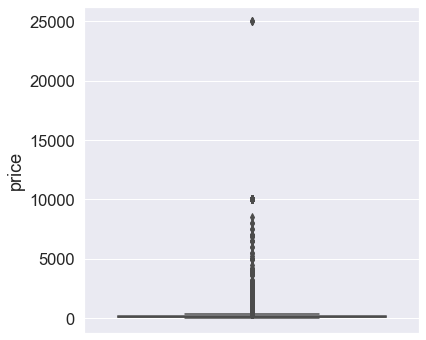

In [28]:
plt.figure(figsize = (6, 6))
sns.boxplot(y = 'price',  data = listings_df)
xt = plt.xticks(rotation=90)

Use the Tukey rule to determine which high price listings are outliers. Therefore, this model will not be useful when pricing high-end listings.

In [29]:
Q1 = listings_df['price'].quantile(0.25)
Q3 = listings_df['price'].quantile(0.75)

IQR = Q3 - Q1
max_value = Q3 + 1.5 * IQR


print("Any listing more than $%d will be discarded" % max_value)
listings_df = listings_df[(listings_df['price'] < max_value)].reset_index(drop=True)

Any listing more than $335 will be discarded


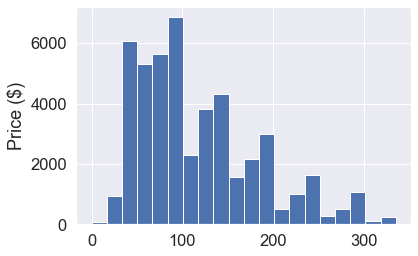

In [30]:
listings_df['price'].hist(bins=20)
plt.ylabel("Count");
plt.ylabel("Price ($)");

Now lets do a first past to examine how much the features seem to matter in predicting price.

In [31]:
def plot_price_dist(df, col):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    sns.boxplot(x = col, y ='price',  data = df, ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    
    
    listings_df[col].value_counts().sort_index().plot(kind='bar', ax=ax2);
    plt.ylabel("Count");
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

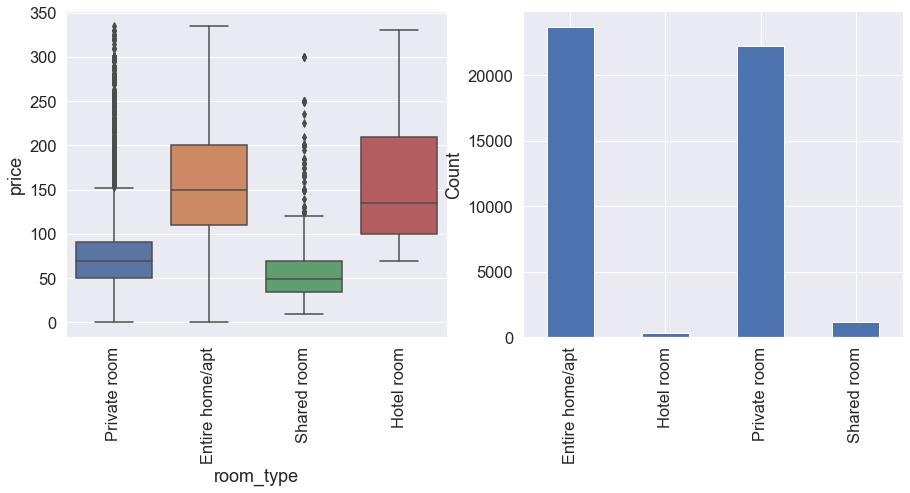

In [32]:
# Room type very much effects 
plot_price_dist(listings_df, 'room_type')

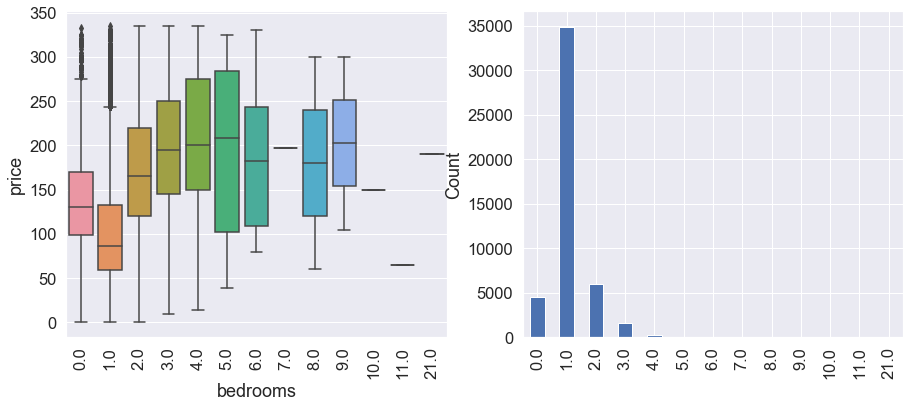

In [33]:
plot_price_dist(listings_df, 'bedrooms')

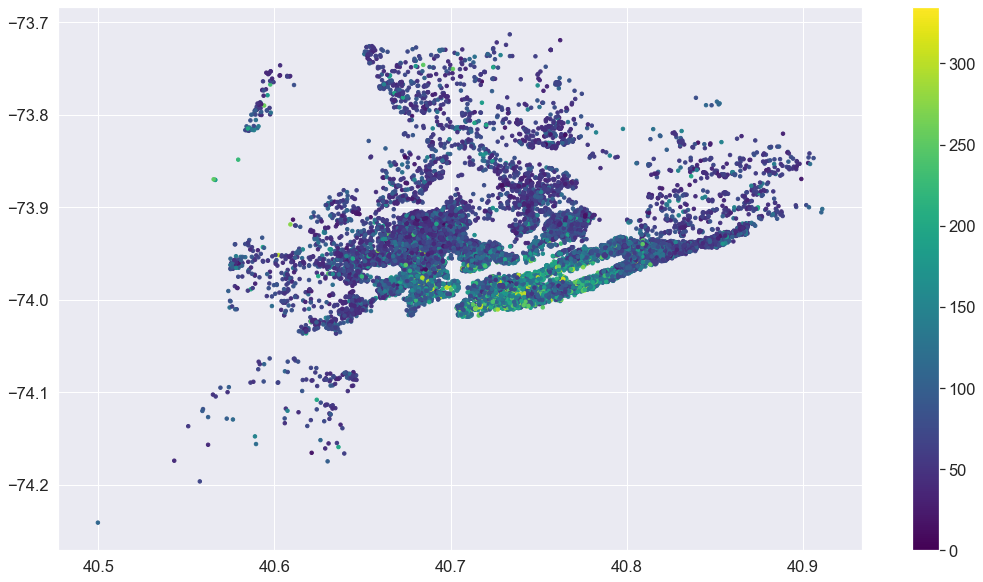

In [497]:
plt.figure(figsize=[18,10])
plt.scatter(listings_df[listings_df['accommodates']==2]['latitude'],
            listings_df[listings_df['accommodates']==2]['longitude'],
            c=listings_df[listings_df['accommodates']==2]['price'], cmap='viridis',s=12)
cbar = plt.colorbar()

# Building a Model

### Can we predict a price just by looking at your neighbors?

For a first try lets use a k-nearest neighbors model. The model is overfitting.

In [63]:
knn_features = listings_df[['longitude', 'latitude','accommodates']]

# Split data into training and test data, and fit a linear model
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(knn_features, price, 
                                                                    test_size=.2, random_state=17)

In [64]:
neigh = KNeighborsRegressor(n_neighbors=5).fit(X_knn_train, y_knn_train)

In [84]:
def print_errors(model, X_train, y_train, X_test, y_test ):
    print("The mean squared error on the train set is $%f" % mean_squared_error(model.predict(X_train), y_train)**0.5)
    print("The mean squared error on the train set is $%f" % mean_squared_error(model.predict(X_test), y_test)**0.5)

In [85]:
print_errors(neigh, X_knn_train, y_knn_train, X_knn_test, y_knn_test)

The mean squared error on the train set is $40.627590
The mean squared error on the train set is $50.267302


In [70]:
neigh_50 = KNeighborsRegressor(n_neighbors=50).fit(X_knn_train, y_knn_train)

In [86]:
print_errors(neigh_50, X_knn_train, y_knn_train, X_knn_test, y_knn_test)

The mean squared error on the train set is $46.272367
The mean squared error on the train set is $48.004564


### A linear model with many features
Now build a linear model with more features to see if we can do better.

In [34]:
features = listings_df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included',
                       'number_of_reviews', 'review_scores_rating']]
price = listings_df['price']

In [35]:
# Add the true/false features and change them from 'f' and 't' to 0 or 1.
tf_cols = ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','instant_bookable',
           'require_guest_profile_picture', 'require_guest_phone_verification']
for col in tf_cols:
    new_feature = listings_df[col].map(lambda s: 0 if s == "f" else 1)
    features.insert(column=col, value=new_feature, loc=0) 

In [36]:
# Convert True/False to 1/0
for col in amenities:
    new_feature = listings_df[col].map(lambda s: 0 if s == False else 1)
    features.insert(column=col, value=new_feature, loc=0) 

Next I will convert categorical features to dummy features

In [37]:
cat_col = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']
for col in cat_col:
    features = pd.concat([features, pd.get_dummies(listings_df[col], prefix=col[0:5], prefix_sep='_', 
                                                   drop_first=True, dummy_na=True)], axis=1)

There are several features that have missing values.

In [38]:
features.columns[features.isnull().mean() > 0]

Index(['bathrooms', 'bedrooms', 'beds', 'review_scores_rating'], dtype='object')

So as to not waste this data I will impute the mean.

In [39]:
fill_mean = lambda col: col.fillna(col.mean()) 
features = features.apply(fill_mean, axis=0) 

This linear model is using 295 features

In [40]:
features.shape

(47366, 296)

In [41]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=.2, random_state=42)

Use a grid search to find an optimal value of the Regularization parameter 'alpha' to prevent overfitting the 296 features.

In [42]:
rid = Ridge()
param_grid = [{'alpha': np.arange(20)*0.2}]
gs = GridSearchCV(estimator=rid, param_grid=param_grid, cv=10)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [43]:
gs.best_params_

{'alpha': 3.0}

In [44]:
rid = gs.best_estimator_.fit(X_train, y_train)

In [87]:
print_errors(rid, X_train, y_train, X_test, y_test)

The mean squared error on the train set is $42.886475
The mean squared error on the train set is $43.029154


In [72]:
def print_imp_features(model, threshold):
    print("Start with $%d" % model.intercept_)
    for i, c in enumerate(model.coef_):
        if c > threshold or c < -threshold:
            print("$%f for %s" % (c, X_train.columns[i]))

In [73]:
# Which features change the price by more than $5
print_imp_features(rid, 5)

Start with $64
$7.018778 for TV
$6.832053 for Washer
$-12.964430 for Fireplace
$8.846192 for Pool
$12.365848 for Gym
$10.320888 for Doorman
$7.514581 for require_guest_phone_verification
$-5.393171 for require_guest_profile_picture
$8.325133 for accommodates
$13.148587 for bedrooms
$-18.571609 for neigh_Arden Heights
$-22.478913 for neigh_Arrochar
$-5.543562 for neigh_Arverne
$-8.609937 for neigh_Bath Beach
$39.531351 for neigh_Battery Park City
$-6.792050 for neigh_Bay Ridge
$-12.467449 for neigh_Bay Terrace, Staten Island
$-7.642003 for neigh_Bayside
$49.640716 for neigh_Belle Harbor
$-11.767573 for neigh_Belmont
$-19.233557 for neigh_Bensonhurst
$-25.794240 for neigh_Bergen Beach
$34.122019 for neigh_Boerum Hill
$-8.466446 for neigh_Borough Park
$41.480439 for neigh_Breezy Point
$-20.642162 for neigh_Bronxdale
$41.868674 for neigh_Brooklyn Heights
$-6.464897 for neigh_Brownsville
$-29.078130 for neigh_Bull's Head
$-6.081596 for neigh_Bushwick
$-9.087755 for neigh_Cambria Heights
$-1

In [48]:
# Here are the very most important features
print_imp_features(rid, 50)

Start with $64
$58.744313 for neigh_Chelsea
$64.922152 for neigh_Flatiron District
$68.879332 for neigh_Greenwich Village
$52.535128 for neigh_Hell's Kitchen
$59.817034 for neigh_Midtown
$70.924814 for neigh_NoHo
$59.909447 for neigh_Nolita
$63.397485 for neigh_SoHo
$76.838074 for neigh_Tribeca
$74.385622 for neigh_West Village
$-69.581813 for prope_Camper/RV
$-69.933329 for room__Shared room


### A nonlinear model
Can a nonlinear regressor do better? Yes, the data has some nonlinearities, (e.g. diminishing price returns for number of bedrooms). 

In [89]:
mlp = MLPRegressor(activation='relu',max_iter=2000, hidden_layer_sizes=(50,8)).fit(X_train, y_train)

In [90]:
print_errors(mlp, X_train, y_train, X_test, y_test)

The mean squared error on the train set is $40.670411
The mean squared error on the train set is $41.742789


In [91]:
np.mean(np.abs(mlp.predict(X_test)- y_test))

29.864798737792437

# Summary

1. The best model can predict past listings to within an average of $30. 
2. The most impactful features are neighborhood, property type, room type, bedrooms, and number of guests accomdated.
3. The most ammmenities most likely to change the value of your listing are having a TV, Washer, Fireplace, Doorman, Gym, or a Pool.